# Assignment 01

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [4]:
class Data:
    
    def __init__(self, size):
        self.size = size
        self.X = np.linspace(0, 1, size)
        self.noise = np.random.normal(0, 0.1, size)
        self.ground_truth = np.sin(2 * np.pi * self.X)
        self.Y = self.ground_truth + self.noise

        self.X_test = self.X[0::2]
        self.X_train = self.X[1::2]
        self.Y_test = self.Y[0::2]
        self.Y_train = self.Y[1::2]

In [5]:
class LinearModel:
    
    def __init__(self, degree: int, hyper_parameter: float = 0):
        self.degree = degree
        self.hyper_parameter = hyper_parameter
        self.model = None
        self.weights = np.array([])

    def train(self, data: Data):
        self.model = make_pipeline(PolynomialFeatures(self.degree),
                                   Ridge(alpha=self.hyper_parameter, solver='auto'))
        self.model.fit(data.X_train[:, np.newaxis], data.Y_train)
        self.weights = self.model.steps[-1][1].coef_.copy()
        self.weights[0] = self.model.steps[-1][1].intercept_
        return self.model

    def predict(self, X):
        return self.model.predict(X[:, np.newaxis])

    def error(self, X, y):
        y_pred = self.predict(X)
        return np.sqrt(mean_squared_error(y, y_pred))

    def plot(self, axis, data: Data):
        x_plot = np.linspace(0, 1, 100)
        y_plot = self.predict(x_plot)

        axis.plot(data.X, data.ground_truth, color='lime')
        axis.scatter(data.X_train, data.Y_train, facecolors='none', edgecolors='b')
        axis.plot(x_plot, y_plot, color='red', label=f'M = {self.degree}')
        axis.set_xlim([None, None])
        axis.set_ylim([-1.5, 1.5])
        axis.legend(loc=2, prop={'size': 15}, frameon=True)

        return axis

20 data points with a 10-train, 10-test split.
<br>
X values in uniform interval [0,1]
<br>
Y values are generated using the formula (y = sin(2*pi*X) + N).

In [6]:
data = Data(20)

Generated and trained 10 models, 1 for each degree in-range [0,9]
<br>
Used scikit-learn to calculate model-weights. 

In [7]:
models = [LinearModel(x) for x in range(10)]
for model in models:
    model.train(data)

Weights for models with the following degrees (0, 1, 6, 9)

In [8]:
orders = [0, 1, 6, 9]
weights = pd.DataFrame()
for order in orders:
    temp = pd.DataFrame({f'M={order}': models[order].weights})
    weights = pd.concat([weights, temp], axis=1)
weights.round(2).fillna('')

,M=0,M=1,M=6,M=9
0,-0.04,0.82,0.03,-4.67
1,,-1.64,3.38,182.64
2,,,22.86,-2397.32
3,,,-126.85,16337.81
4,,,176.35,-64566.51
5,,,-88.92,156073.81
6,,,13.13,-234469.66
7,,,,213515.08
8,,,,-107797.23
9,,,,23126.01


Plotting models of the following degrees (0, 1, 6, 9)

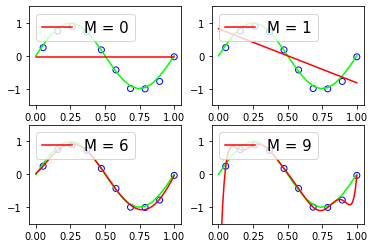

In [9]:
figure, axis = plt.subplots(2, 2)
for i, order in enumerate(orders):
    models[order].plot(axis[i // 2][ i % 2], data)
plt.show()

The model-plot for [degree = 9] is an overfit.

Plotting the RMS error for each model

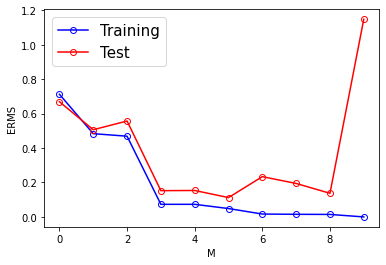

In [36]:
train_errors = []
test_errors = []
degs = list(range(len(models)))
for model in models:
    train_errors.append(model.error(data.X_train, data.Y_train))
    test_errors.append(model.error(data.X_test, data.Y_test))
figure = plt.figure()
axis = figure.add_subplot(1, 1, 1)
axis.plot(degs, train_errors, color='blue', marker='o', markerfacecolor='none', label='Training')
axis.plot(degs, test_errors, color='red', marker='o', markerfacecolor='none', label='Test')
axis.set_ylabel('ERMS')
axis.set_xlabel('M')
axis.legend(loc=2, prop={'size': 15}, frameon=True)
plt.show()

Generating 100 new data points and fitting model(degree=9).

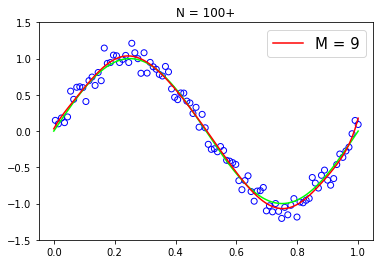

In [37]:
large_data = Data(200)
model9 = LinearModel(9)
model9.train(large_data)
figure, axis = plt.subplots()
model9.plot(axis, large_data)
plt.title('N = 100+')
axis.legend(loc=1, prop={'size': 15}, frameon=True)
plt.show()

The new model doesn't overfit due to the increased amount of data.

Trainnig 6 new models using regularization with λ = (1, 1/10, 1/100, 1/1000, 1/10000, 1/100000)

In [38]:
hy_pams = list(10 ** -x for x in range(6))
models = [LinearModel(9, hp) for hp in hy_pams]
for model in models:
    model.train(data)

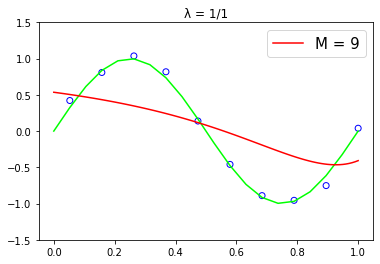

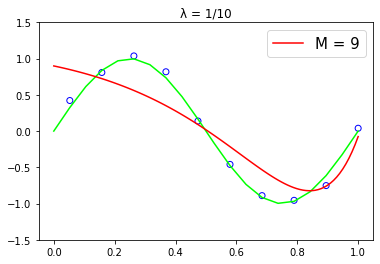

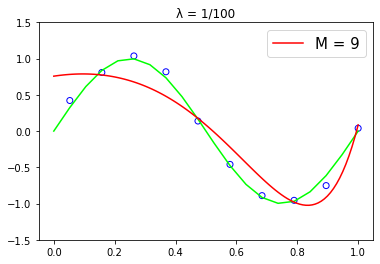

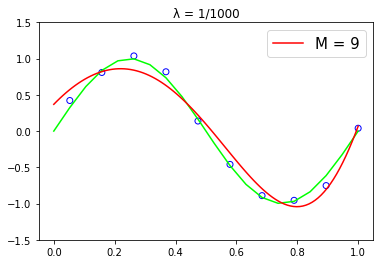

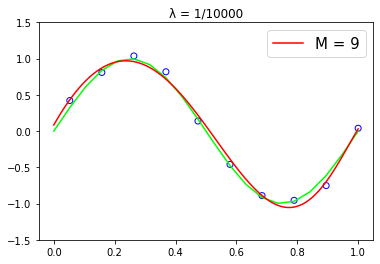

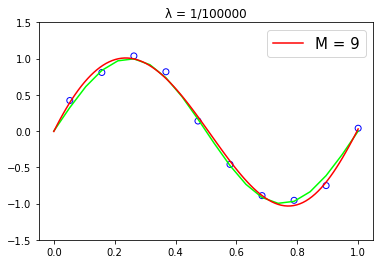

In [39]:
for i, hp in enumerate(hy_pams):
    figure, axis = plt.subplots()
    models[i].plot(axis, data)
    plt.title(f'λ = 1/{1/hp:.0f}')
    axis.legend(loc=1, prop={'size': 15}, frameon=True)
    plt.show() 

Training  new models using hyper parameters ln(λ) = [-30, -4]

In [40]:
hy_pams = np.arange(-30,-4)
models = [LinearModel(9, np.exp(hp)) for hp in hy_pams]
for model in models:
    model.train(data)

Plotting training and test error for new models.

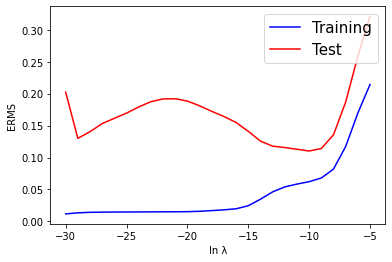

In [41]:
training_err = []
test_errors = []

for model in models:
    training_err.append(model.error(data.X_train, data.Y_train))
    test_errors.append(model.error(data.X_test, data.Y_test))
    
figure = plt.figure()
axis = figure.add_subplot(1, 1, 1)
axis.plot(hy_pams, training_err, color='blue', label='Training')
axis.plot(hy_pams, test_errors, color='red', label='Test')
axis.set_ylabel('ERMS')
axis.set_xlabel('ln λ')
axis.legend(loc=1, prop={'size': 15}, frameon=True)
plt.show()

the model with lowest test error.

In [42]:
minimum = np.argmin(test_errors)
best_perf = models[minimum]
with np.printoptions(precision=4, suppress=True):
    print(f'Based on the test performance, the best model with deg 9 is ln λ = {np.log(best_perf.hyper_parameter)}')
    print(f'Weights: {best_perf.weights}')

Based on the test performance, the best model with deg 9 is ln λ = -10.0
Weights: [  0.0364   8.0131 -16.1439  -5.0801   6.2322   8.1053   4.1922  -0.5113
  -2.9369  -1.8788]


Plotting the best model found above.

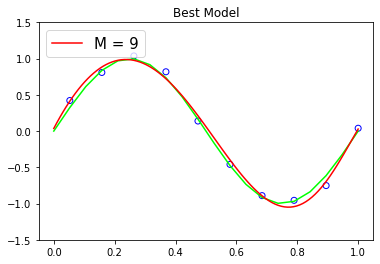

In [43]:
figure, axis = plt.subplots()
best_perf.plot(axis, data)
plt.title('Best Model')
plt.show()